In [260]:
import glob
from astropy import table
from astropy.io import ascii
import numpy as np
import matplotlib.pyplot as plt
import	multiprocessing as mp
#from plotsettings_py36 import *
from scipy import interpolate
import scipy
import scipy.optimize
from scipy.optimize import curve_fit
import time
import pandas as pd 
from scipy import stats
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d


# (Super) Functions

In [261]:
def cartesian_product(*arrays):
    la = len(arrays)
    dtype = np.result_type(*arrays)
    arr = np.empty([len(a) for a in arrays] + [la], dtype=dtype)
    for i, a in enumerate(np.ix_(*arrays)):
        arr[...,i] = a
    return arr.reshape(-1, la)

In [262]:
#lam is in angtroms 
#A_v is a user input

import extinction

A_v = 1.0

def Alam(lamin, A_v):

    lam=np.zeros(len(lamin))
    redreturn=np.zeros(len(lamin))

    #Add extinction with R_v= 3.1 and A_v = 1     
    extinction.ccm89(lam, A_v, 3.1)
        
    return redreturn


In [263]:
def select_templates(DATABASE, TYPES):

       
#    Selects templates of a given type(s) from a template database
    
#    Input: DATEBASE   list of templates
#           TYPES      which types should be selected
    
#    Output: array of templates of given type(s)
       
    database_trunc = list([])
    
    for type in TYPES:
        database_trunc += list([x for x in DATABASE if type in x])
    
    return np.array(database_trunc)

## Get Sigma

In [264]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.optimize
from scipy.optimize import curve_fit
import statistics 

def error_spectra(spec_object): 

    flux = spec_object[:,1]
    lam  = spec_object[:,0]

#For how many points do we make the lines
    num=10

    if len(flux)%num != 0:
        c = len(flux)%num
        flux = flux[:-c]
        lams = lam[:-c]
    
    
    flux_new = flux.reshape((-1,num))
    lam_new  = lams.reshape((-1,num))
    m = []
    b = []
    sigma = []

    for n in range(len(lam_new)):
        r=[]
        error=[]
        
        a = np.polyfit(lam_new[n], flux_new[n], 1)
        m.append(a[0])
        b.append(a[1])
        y = m[n]*lam_new[n]+b[n]
          
        r = flux_new - y
        
        plt.plot(lam_new[n], flux_new[n], '.' )
        plt.plot(lam_new[n], y)
        plt.plot(lam_new[n], flux_new[n]-y, 'ko', markersize=1)
       
        plt.title('For n*10th Entry')
        plt.ylabel('Flux')
        plt.xlabel('Lamda')
    

    for i in r: 
        s = statistics.stdev(i)
        sigma.append(s)
    

# Here we make the error be the same size as the original lambda and then take the transpose

    error = list(np.repeat(sigma, num))
    l = [error[-1]] * c
    error = error + l

    error = np.asarray(error)
    
    return np.array([lam,error]).T

# Compute the (Super) fit

In [265]:
from scipy.interpolate import interp1d


def wrapper_fit(DATABASE):

    """
    Compute the fit
    """
   
    # 1) File i/o
    
    spec_gal    = np.loadtxt(DATABASE['GALAXY'])
    spec_SN     = np.loadtxt(DATABASE['SN'])
    spec_object = np.loadtxt(DATABASE['OBJECT'])
    error       = error_spectra(spec_object)
    #spec_object[:,1]*=10
   
    # 3) Interpolate spectra
    
    spec_gal_interp    = interpolate.interp1d(spec_gal[:,0],    spec_gal[:,1],    bounds_error=False, fill_value=np.nan)
    spec_sn_interp     = interpolate.interp1d(spec_SN[:,0],     spec_SN[:,1],     bounds_error=False, fill_value=np.nan)
    spec_object_interp = interpolate.interp1d(spec_object[:,0], spec_object[:,1], bounds_error=False, fill_value=np.nan)
    spec_object_err_interp = interpolate.interp1d(error[:,0],     error[:,1],     bounds_error=False, fill_value=np.nan)
    
    # Determine the common wavelength range
    
    lambda_min = max([spec_gal[:,0][0],  spec_SN[:,0][0],  spec_object[:,0][0]])
    lambda_max = min([spec_gal[:,0][-1], spec_SN[:,0][-1], spec_object[:,0][-1]])
    
    # Truncate wavelength interval
    
    lambda_new= spec_object[:,0][ (spec_object[:,0] >= lambda_min) & (spec_object[:,0] <= lambda_max) ]
    
    # 4) Fit function

    def func(x, b, d, z, c):
        return b * spec_sn_interp(x/(z+1))*10**(c*Alam(x,1)) + d * spec_gal_interp(x/(z+1))

    # fitting
     
    result = curve_fit(func, lambda_new, spec_object_interp(lambda_new), sigma=spec_object_err_interp(lambda_new),
                      p0=[1,1,0,1])
    print(result)
    popt   = result[0]
    pcov   = result[1]
    
    # Compute chi^2
    #sigma = 1
    sigma = spec_object_err_interp(lambda_new)
    chi2   = np.sum(((spec_object_interp(lambda_new)-func(lambda_new, *popt))/sigma)**2)
    #print(DATABASE['GALAXY'], DATABASE['SN'])

    print(sigma)
    output=table.Table(
            np.array([DATABASE['OBJECT'], DATABASE['GALAXY'], DATABASE['SN'], chi2, popt[0], popt[1], popt[2], popt[3], np.sqrt(pcov[0,0]), 0]), 
            names=('OBJECT', 'GALAXY', 'SN', 'CHI2', 'CONST_SN', 'CONST_GAL', 'CONST_Z', 'CONST_C' , 'CONST_SN_ERR', 'CONST_EXT_ERR'), 
            dtype=('S100', 'S100', 'S100', 'f', 'f', 'f', 'f', 'f', 'f', 'f'))
    
    
    return output
    

# Read in spectral database

In [266]:

templates_gal = glob.glob('rebinned/gal/*')
templates_gal = [x for x in templates_gal if 'CVS' not in x and 'README' not in x]
templates_gal = np.array(templates_gal)

templates_sn = glob.glob('rebinned/sne/**/*')
templates_sn = [x for x in templates_sn if 'CVS' not in x and 'README' not in x]
templates_sn = np.array(templates_sn)

#These parameters are user inputs 
templates_dust = np.array([-0.2, 0.1])

## Truncate templates SN, HG


In [267]:
#Truncate the SN 
templates_sn_trunc = select_templates(templates_sn, ['/Ia/' , '/Ib/','II'])
#templates_sn_trunc = select_templates(templates_sn, ['/Ic/'])

#Truncate the host galaxy
templates_gal_trunc = select_templates(templates_gal, ['/SB1'])


# Compute the cartesian product of SN templates, galaxy templates and extinction measurements

In [268]:
cartesian_product_all=cartesian_product(*[templates_gal_trunc[:1], templates_sn_trunc, templates_dust[:1]])
cartesian_product_all=table.Table(cartesian_product_all, names=('GALAXY', 'SN', 'DUST'))

#In brakets here is the number of template I'm using to match
cartesian_product_all['OBJECT']=["rebinned/combined/sn1979C.p72.II.SB1"]


cartesian_product_all

GALAXY,SN,DUST,OBJECT
str34,str34,str34,str36
rebinned/gal/SB1,rebinned/sne/Ia/sn1989b.p14.dat,-0.2,rebinned/combined/sn1979C.p72.II.SB1
rebinned/gal/SB1,rebinned/sne/Ia/sn1981b.max.dat,-0.2,rebinned/combined/sn1979C.p72.II.SB1
rebinned/gal/SB1,rebinned/sne/Ia/sn1992a.p28.dat,-0.2,rebinned/combined/sn1979C.p72.II.SB1
rebinned/gal/SB1,rebinned/sne/Ia/sn1998bu.p27.dat,-0.2,rebinned/combined/sn1979C.p72.II.SB1
rebinned/gal/SB1,rebinned/sne/Ia/sn1990n.m07.dat,-0.2,rebinned/combined/sn1979C.p72.II.SB1
rebinned/gal/SB1,rebinned/sne/Ia/sn1999aa.p06.dat,-0.2,rebinned/combined/sn1979C.p72.II.SB1
rebinned/gal/SB1,rebinned/sne/Ia/sn1986g.m03.dat,-0.2,rebinned/combined/sn1979C.p72.II.SB1
rebinned/gal/SB1,rebinned/sne/Ia/sn1989b.m07.dat,-0.2,rebinned/combined/sn1979C.p72.II.SB1
rebinned/gal/SB1,rebinned/sne/Ia/sn1999aa.m01.dat,-0.2,rebinned/combined/sn1979C.p72.II.SB1


In [269]:
index_array=range(len(cartesian_product_all))
index_array

range(0, 329)

In [270]:
%%capture
output=wrapper_fit(cartesian_product_all[0])
output

In [271]:
%%capture

if mp.cpu_count() > 1:
     number_cpu	= mp.cpu_count()/2	# is equal to number of threads x number of physical cpus, e.g. 2x4
else:
    number_cpu	= mp.cpu_count()
number_cpu
pool	= mp.Pool(processes=int(number_cpu)*2)


In [272]:
result = pool.map(wrapper_fit, cartesian_product_all)

In [ ]:
result=table.vstack(result)

In [ ]:
%%capture
result=[wrapper_fit(x) for x in cartesian_product_all]
result=table.vstack(result)

In [ ]:
result.sort('CHI2')
result

OBJECT,GALAXY,SN,CHI2,CONST_SN,CONST_GAL,CONST_Z,CONST_C,CONST_SN_ERR,CONST_EXT_ERR
bytes100,bytes100,bytes100,float32,float32,float32,float32,float32,float32,float32
rebinned/combined/sn1979C.p72.II.SB1,rebinned/gal/SB1,rebinned/sne/II/sn1979C.p72.dat,0.0,1.0,1.0,0.0,1.0,inf,0.0
rebinned/combined/sn1979C.p72.II.SB1,rebinned/gal/SB1,rebinned/sne/Ia/sn1989b.m03.dat,25.745718,-0.2675479,1.644681,-0.0017612302,1.0,inf,0.0
rebinned/combined/sn1979C.p72.II.SB1,rebinned/gal/SB1,rebinned/sne/Ia/sn1989b.m02.dat,28.323742,0.0032662537,1.4799305,-0.0021343438,1.0,inf,0.0
rebinned/combined/sn1979C.p72.II.SB1,rebinned/gal/SB1,rebinned/sne/II/sn1980K.p41.dat,48.783596,0.93649036,0.9649995,-0.002178027,1.0,inf,0.0
rebinned/combined/sn1979C.p72.II.SB1,rebinned/gal/SB1,rebinned/sne/Ia/sn1992a.p46.dat,50.505375,0.1678032,1.2948143,0.0009181967,1.0,inf,0.0
rebinned/combined/sn1979C.p72.II.SB1,rebinned/gal/SB1,rebinned/sne/Ib/sn1984L.p30.dat,52.879326,0.36635327,1.3334831,-0.0013868092,1.0,inf,0.0
rebinned/combined/sn1979C.p72.II.SB1,rebinned/gal/SB1,rebinned/sne/Ia/sn1981b.p58.dat,53.781578,0.2720051,1.3508911,0.000512413,1.0,inf,0.0
rebinned/combined/sn1979C.p72.II.SB1,rebinned/gal/SB1,rebinned/sne/Ia/sn1986g.p22.dat,60.17013,0.25224906,1.4202626,3.3083234e-05,1.0,inf,0.0
rebinned/combined/sn1979C.p72.II.SB1,rebinned/gal/SB1,rebinned/sne/Ia/sn2001ay.p16.dat,65.689255,0.55945265,1.1652249,0.005334863,1.0,inf,0.0


# (Super) Graph

In [ ]:
def visualise_match(DATABASE):

    # File i/o
    
#    print(DATABASE)
    
    spec_gal    = np.loadtxt(DATABASE['GALAXY'][0])
    spec_SN     = np.loadtxt(DATABASE['SN'][0])
    spec_object = np.loadtxt(DATABASE['OBJECT'][0])
    #spec_object[:,1]*=10

    # Plot data
    """
    bestfit_galaxy = DATABASE['GALAXY'].split('/')[-1]
    bestfit_sn_name = DATABASE['SN'].split('/')[2].split('.')[0]
    bestfit_sn_type = DATABASE['SN'].split('/')[1]
    bestfit_sn_phase = '+' + DATABASE['SN'].split('/')[2].split('.')[1].replace('p', '') if 'p' in DATABASE['SN'].split('/')[2].split('.')[1] else '-' + DATABASE['SN'].split('/')[2].split('.')[1].replace('m', '')
    """
    
    
    lambda_min = max([spec_gal[:,0][0],  spec_SN[:,0][0]])
    lambda_max = min([spec_gal[:,0][-1], spec_SN[:,0][-1]])
    
    lam = spec_SN[:,0][ (spec_SN[:,0] >= lambda_min) & (spec_SN[:,0] <= lambda_max) ]
    
    spec_gal_interp  = interpolate.interp1d(spec_gal[:,0], spec_gal[:,1], bounds_error=False, fill_value=np.nan)
    spec_sn_interp  = interpolate.interp1d(spec_SN[:,0], spec_SN[:,1],  bounds_error=False, fill_value=np.nan)
    
    combined = spec_gal_interp(lam) + spec_sn_interp(lam)
   
    plt.figure(figsize=(7*np.sqrt(2), 7))
    
    ax = plt.subplot(111)
    ax.plot(spec_object[:,0], spec_object[:,1], 'm' , lw=5, label='Input spectrum')
#    ax.plot(spec_gal[:,0], DATABASE['CONST_GAL'] * spec_gal[:,1], lw=1, label='Galaxy template')#: {}'.format(bestfit_galaxy))
#    ax.plot(spec_SN[:,0],  DATABASE['CONST_SN']  * spec_SN[:,1],  lw=1, label='SN template')#: {name} ({type}, {phase} days)'.format(type=bestfit_sn_type, name=bestfit_sn_name, phase=bestfit_sn_phase))
    ax.plot(lam, combined, 'k' ,lw=2, label='Galaxy template')
  
    
    
    ax.legend()#fontsize=legend_size-4)
    
    ax.set_xlabel('Observed wavelength (\\AA)')
    ax.set_ylabel('Flux density (arbitary units)')
    
    ax.set_xlim(spec_object[0,0]-20, spec_object[-1,0]-20)
    ax.set_ylim(0, max(spec_object[:,1])*1.2)
    
    plt.show()


In [ ]:
result[0]['OBJECT']

'rebinned/combined/sn1979C.p72.II.SB1'

<Table length=1>
     name      dtype   n_bad
------------- -------- -----
       OBJECT bytes100     0
       GALAXY bytes100     0
           SN bytes100     0
         CHI2  float32     0
     CONST_SN  float32     0
    CONST_GAL  float32     0
      CONST_Z  float32     0
      CONST_C  float32     0
 CONST_SN_ERR  float32     1
CONST_EXT_ERR  float32     0
None


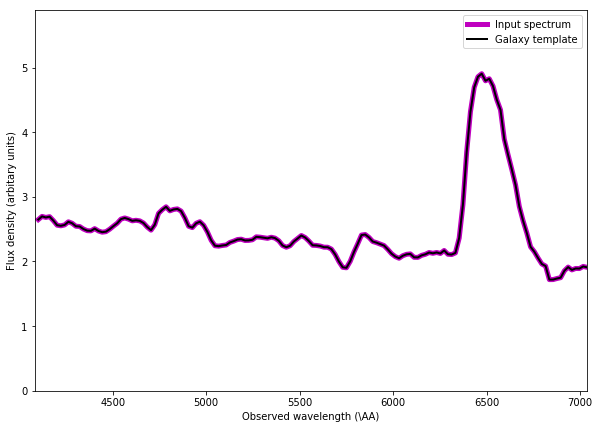

In [ ]:
print(output.info())
visualise_match(table.Table(result[0]))

In [ ]:
import os
os.getcwd()

'/Users/user/Desktop/ssf/superfit'

In [ ]:
%%capture
[wrapper_fit(x) for x in cartesian_product_all]

In [ ]:
#In order to identify the files giving me trouble

for file in np.unique(cartesian_product_all['SN']):
    try:
        np.loadtxt(file)
    except:
        print(file)
